In [ ]:
import ast
import math
import pickle
import random
import json
import warnings
from collections import Counter, deque
import copy

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import (
    accuracy_score, average_precision_score, f1_score,
    precision_score, recall_score, roc_auc_score, classification_report,
    precision_recall_curve
)
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

from iterstrat.ml_stratifiers import (
    MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit
)

from utils_corrected import *

/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
ontology = 'CCO'
ontology_type = 'component'

test_embeddings_path = r'processed_data_90_30/{0}_test.npy'.format(ontology_type)
test_tsv_path = r'processed_data_90_30/{0}_test.tsv'.format(ontology_type)


test_embeddings = np.load(test_embeddings_path)
test_GO_df, test_embeddings, test_GO_list, test_GO_annotated = process_GO_data(test_tsv_path, test_embeddings)

print("test embeddings shape:", test_embeddings.shape)

with open('{0}_mlb.pkl'.format(ontology_type), 'rb') as f:
    mlb = pickle.load(f)

test_labels = mlb.transform(test_GO_list)

print("test labels shape:", test_labels.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
test_dataset = TensorDataset(torch.tensor(test_embeddings, dtype=torch.float).to(device),
                                   torch.tensor(test_labels, dtype=torch.float).to(device))

test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

test embeddings shape: (29679, 512)
test labels shape: (29679, 255)
Using device: cpu


In [ ]:
with open(r'cc_uncertainty_results/arrays/ensemble_20_central.npy', 'rb') as f:
    median = np.load(f, allow_pickle=True)

with open(r'cc_uncertainty_results/arrays/ensemble_20_uncertainty.npy', 'rb') as f:
    mad = np.load(f, allow_pickle=True)

print(median.shape)
print(mad.shape)


(29679, 255)
(29679, 255)


In [ ]:
with open(r'processed_data_90_30/trained_component_ALL_data_ancestors_dict.json') as f:
    trained_function_ALL_data_ancestors_dict = json.load(f)

terms_not_in_test = test_labels.sum(axis=0) == 0
terms_not_in_test = np.where(terms_not_in_test)[0]
print("Number of terms not in test:", len(terms_not_in_test))

terms_not_in_test = mlb.classes_[terms_not_in_test]

terms_in_test = test_labels.sum(axis=0) != 0
terms_in_test = np.where(terms_in_test)[0]
print("Number of terms in test:", len(terms_in_test))

terms_in_test = mlb.classes_[terms_in_test]

terms_not_in_test, terms_in_test

Number of terms not in test: 9
Number of terms in test: 246


(array(['GO:0000120', 'GO:0009295', 'GO:0009528', 'GO:0031256',
        'GO:0031969', 'GO:0043005', 'GO:0071013', 'GO:0097730',
        'GO:0097732'], dtype=object),
 array(['GO:0000109', 'GO:0000118', 'GO:0000123', 'GO:0000151',
        'GO:0000152', 'GO:0000153', 'GO:0000178', 'GO:0000228',
        'GO:0000307', 'GO:0000313', 'GO:0000314', 'GO:0000315',
        'GO:0000323', 'GO:0000347', 'GO:0000428', 'GO:0000502',
        'GO:0000793', 'GO:0000808', 'GO:0000835', 'GO:0000836',
        'GO:0000930', 'GO:0005575', 'GO:0005667', 'GO:0005681',
        'GO:0005684', 'GO:0005694', 'GO:0005697', 'GO:0005732',
        'GO:0005764', 'GO:0005767', 'GO:0005768', 'GO:0005770',
        'GO:0005773', 'GO:0005774', 'GO:0005813', 'GO:0005815',
        'GO:0005819', 'GO:0005840', 'GO:0005849', 'GO:0005852',
        'GO:0005856', 'GO:0005858', 'GO:0005874', 'GO:0005875',
        'GO:0005881', 'GO:0005886', 'GO:0005911', 'GO:0005929',
        'GO:0005942', 'GO:0008023', 'GO:0008287', 'GO:0008303',
  

In [ ]:
import obonet
go_graph = obonet.read_obo('go-basic.obo')

go_graph = nx.subgraph_view(go_graph, filter_node=lambda n: n.startswith("GO:"))


sorted_go_terms = list(nx.topological_sort(go_graph))


go_order = {term: idx for idx, term in enumerate(sorted_go_terms)}

sorted_trained_function_ALL_data_ancestors_dict = {}

for term, ancestors in trained_function_ALL_data_ancestors_dict.items():
    sorted_ancestors = sorted(ancestors, key=lambda t: go_order.get(t, float('inf')))
    sorted_trained_function_ALL_data_ancestors_dict[term] = sorted_ancestors


for term, sorted_ancestors in sorted_trained_function_ALL_data_ancestors_dict.items():
    print(f"{term}: {sorted_ancestors}")

GO:0097732: ['GO:0097732', 'GO:0097730', 'GO:0005929', 'GO:0120025', 'GO:0042995', 'GO:0043227', 'GO:0043226', 'GO:0110165', 'GO:0005575']
GO:0034357: ['GO:0034357', 'GO:0016020', 'GO:0110165', 'GO:0005575']
GO:0071010: ['GO:0071010', 'GO:0005681', 'GO:0140513', 'GO:1990904', 'GO:0032991', 'GO:0005575']
GO:0071013: ['GO:0071013', 'GO:0005681', 'GO:0140513', 'GO:1990904', 'GO:1902494', 'GO:0032991', 'GO:0005575']
GO:0000835: ['GO:0000835', 'GO:0000153', 'GO:0140534', 'GO:0000151', 'GO:0140535', 'GO:1990234', 'GO:0098796', 'GO:1902494', 'GO:0032991', 'GO:0005575']
GO:1902554: ['GO:1902554', 'GO:1902911', 'GO:0061695', 'GO:1990234', 'GO:1902494', 'GO:0032991', 'GO:0005575']
GO:1902562: ['GO:1902562', 'GO:0000123', 'GO:0031248', 'GO:1902493', 'GO:0140535', 'GO:1990234', 'GO:1902494', 'GO:0032991', 'GO:0005575']
GO:1902495: ['GO:1902495', 'GO:0098796', 'GO:1990351', 'GO:0032991', 'GO:0005575']
GO:0043527: ['GO:0043527', 'GO:0034708', 'GO:1990234', 'GO:1902494', 'GO:0032991', 'GO:0005575']
G

In [ ]:
sorted_trained_function_ALL_data_ancestors_dict = {term: [a for a in ancestors if a in mlb.classes_] for term, ancestors in sorted_trained_function_ALL_data_ancestors_dict.items()}
sorted_trained_function_ALL_data_ancestors_dict

{'GO:0097732': ['GO:0097732',
  'GO:0097730',
  'GO:0005929',
  'GO:0120025',
  'GO:0042995',
  'GO:0043227',
  'GO:0043226',
  'GO:0110165',
  'GO:0005575'],
 'GO:0034357': ['GO:0034357', 'GO:0016020', 'GO:0110165', 'GO:0005575'],
 'GO:0071010': ['GO:0071010',
  'GO:0005681',
  'GO:0140513',
  'GO:1990904',
  'GO:0032991',
  'GO:0005575'],
 'GO:0071013': ['GO:0071013',
  'GO:0005681',
  'GO:0140513',
  'GO:1990904',
  'GO:1902494',
  'GO:0032991',
  'GO:0005575'],
 'GO:0000835': ['GO:0000835',
  'GO:0000153',
  'GO:0140534',
  'GO:0000151',
  'GO:0140535',
  'GO:1990234',
  'GO:0098796',
  'GO:1902494',
  'GO:0032991',
  'GO:0005575'],
 'GO:1902554': ['GO:1902554',
  'GO:1902911',
  'GO:0061695',
  'GO:1990234',
  'GO:1902494',
  'GO:0032991',
  'GO:0005575'],
 'GO:1902562': ['GO:1902562',
  'GO:0000123',
  'GO:0031248',
  'GO:1902493',
  'GO:0140535',
  'GO:1990234',
  'GO:1902494',
  'GO:0032991',
  'GO:0005575'],
 'GO:1902495': ['GO:1902495',
  'GO:0098796',
  'GO:1990351',
  'GO:0

In [ ]:
closest_terms_sorted = {}
for term in terms_not_in_test:
    closest = find_closest_term_from_sorted(term, set(terms_in_test), sorted_trained_function_ALL_data_ancestors_dict)
    closest_terms_sorted[term] = closest

for term, closest in closest_terms_sorted.items():
    if closest is not None:
        print(f"For term {term}, the closest valid term (using sorted ancestors) is {closest}")
    else:
        print(f"For term {term}, no valid term was found from the sorted ancestors.")


For term GO:0000120, the closest valid term (using sorted ancestors) is GO:0005667
For term GO:0009295, the closest valid term (using sorted ancestors) is GO:0110165
For term GO:0009528, the closest valid term (using sorted ancestors) is GO:0019866
For term GO:0031256, the closest valid term (using sorted ancestors) is GO:0110165
For term GO:0031969, the closest valid term (using sorted ancestors) is GO:0042170
For term GO:0043005, the closest valid term (using sorted ancestors) is GO:0120025
For term GO:0071013, the closest valid term (using sorted ancestors) is GO:0005681
For term GO:0097730, the closest valid term (using sorted ancestors) is GO:0005929
For term GO:0097732, the closest valid term (using sorted ancestors) is GO:0005929


Tuning lambda:   5%|▌         | 1/20 [00:01<00:33,  1.77s/it]

Lambda: 0.10, Valid terms: 206 out of 255


Tuning lambda:  10%|█         | 2/20 [00:03<00:31,  1.74s/it]

Lambda: 0.20, Valid terms: 206 out of 255


Tuning lambda:  15%|█▌        | 3/20 [00:05<00:29,  1.73s/it]

Lambda: 0.30, Valid terms: 208 out of 255


Tuning lambda:  20%|██        | 4/20 [00:06<00:27,  1.71s/it]

Lambda: 0.40, Valid terms: 209 out of 255


Tuning lambda:  25%|██▌       | 5/20 [00:08<00:25,  1.70s/it]

Lambda: 0.50, Valid terms: 208 out of 255


Tuning lambda:  30%|███       | 6/20 [00:10<00:24,  1.74s/it]

Lambda: 0.60, Valid terms: 209 out of 255


Tuning lambda:  35%|███▌      | 7/20 [00:12<00:22,  1.71s/it]

Lambda: 0.70, Valid terms: 208 out of 255


Tuning lambda:  40%|████      | 8/20 [00:13<00:20,  1.69s/it]

Lambda: 0.80, Valid terms: 208 out of 255


Tuning lambda:  45%|████▌     | 9/20 [00:15<00:18,  1.66s/it]

Lambda: 0.90, Valid terms: 205 out of 255


Tuning lambda:  50%|█████     | 10/20 [00:16<00:16,  1.65s/it]

Lambda: 1.00, Valid terms: 206 out of 255


Tuning lambda:  55%|█████▌    | 11/20 [00:18<00:14,  1.63s/it]

Lambda: 1.10, Valid terms: 208 out of 255


Tuning lambda:  60%|██████    | 12/20 [00:20<00:12,  1.61s/it]

Lambda: 1.20, Valid terms: 207 out of 255


Tuning lambda:  65%|██████▌   | 13/20 [00:21<00:11,  1.60s/it]

Lambda: 1.30, Valid terms: 206 out of 255


Tuning lambda:  70%|███████   | 14/20 [00:23<00:09,  1.60s/it]

Lambda: 1.40, Valid terms: 203 out of 255


Tuning lambda:  75%|███████▌  | 15/20 [00:24<00:08,  1.63s/it]

Lambda: 1.50, Valid terms: 206 out of 255


Tuning lambda:  80%|████████  | 16/20 [00:26<00:06,  1.59s/it]

Lambda: 1.60, Valid terms: 208 out of 255


Tuning lambda:  85%|████████▌ | 17/20 [00:27<00:04,  1.57s/it]

Lambda: 1.70, Valid terms: 207 out of 255


Tuning lambda:  90%|█████████ | 18/20 [00:29<00:03,  1.57s/it]

Lambda: 1.80, Valid terms: 204 out of 255


Tuning lambda:  95%|█████████▌| 19/20 [00:31<00:01,  1.55s/it]

Lambda: 1.90, Valid terms: 203 out of 255


Tuning lambda: 100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


Lambda: 2.00, Valid terms: 204 out of 255

Best lambda is 0.40 with 209 valid terms.


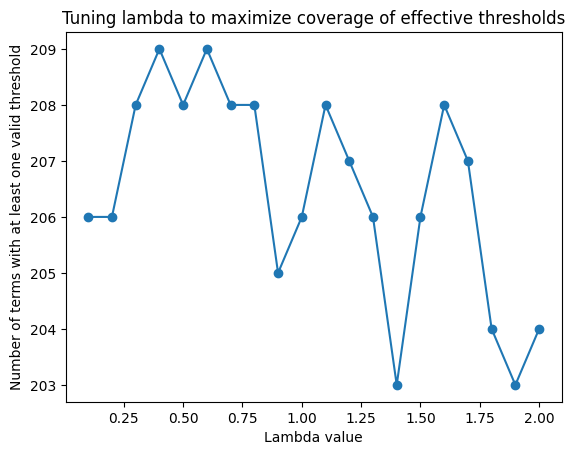

In [ ]:
candidate_thresholds = np.arange(0.01, 1.0, 0.1)
target_fdrs = np.arange(0.01, 0.61, 0.1)


lambda_values = np.linspace(0.1, 2.0, 20)

results = {}
for lambda_val in tqdm(lambda_values, desc="Tuning lambda"):
    valid_count, _ = count_valid_terms(lambda_val, median, mad, test_labels, candidate_thresholds, target_fdrs)
    results[lambda_val] = valid_count
    print(f"Lambda: {lambda_val:.2f}, Valid terms: {valid_count} out of {test_labels.shape[1]}")

best_lambda = max(results, key=results.get)
print(f"\nBest lambda is {best_lambda:.2f} with {results[best_lambda]} valid terms.")

plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.xlabel("Lambda value")
plt.ylabel("Number of terms with at least one valid threshold")
plt.title("Tuning lambda to maximize coverage of effective thresholds")
plt.show()


In [ ]:
candidate_thresholds = np.arange(0.01, 1.0, 0.01)
target_fdrs = np.arange(0.01, 0.5, 0.01)

effective_thresholds = compute_all_effective_thresholds(
    median, 
    mad,
    test_labels, 
    candidate_thresholds, 
    target_fdrs, 
    lambda_val=1, 
    smoothing=1e-6
)

Computing effective thresholds: 100%|██████████| 255/255 [01:20<00:00,  3.18it/s]


In [ ]:
effective_thresholds = {mlb.classes_[k]: v for k, v in effective_thresholds.items()} 

In [12]:
for term, closest in closest_terms_sorted.items():
    if closest is not None:
        print(f"Updating thresholds for {term} using closest valid term {closest}")
        effective_thresholds[term] = effective_thresholds[closest]
    else:
        print(f"No valid closest term found for {term}. Thresholds remain unchanged.")


Updating thresholds for GO:0000120 using closest valid term GO:0005667
Updating thresholds for GO:0009295 using closest valid term GO:0110165
Updating thresholds for GO:0009528 using closest valid term GO:0019866
Updating thresholds for GO:0031256 using closest valid term GO:0110165
Updating thresholds for GO:0031969 using closest valid term GO:0042170
Updating thresholds for GO:0043005 using closest valid term GO:0120025
Updating thresholds for GO:0071013 using closest valid term GO:0005681
Updating thresholds for GO:0097730 using closest valid term GO:0005929
Updating thresholds for GO:0097732 using closest valid term GO:0005929


In [ ]:
with open('effective_thresholds_ensemble20_{0}.json'.format(ontology_type), 'w') as f:
    json.dump(effective_thresholds, f)

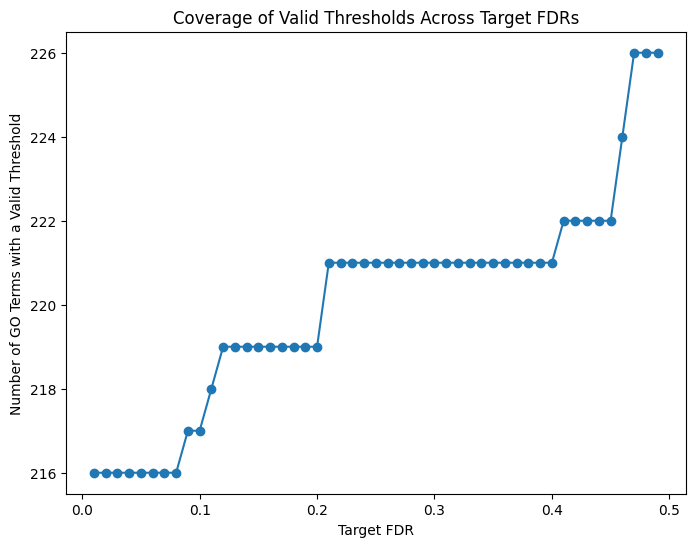

In [ ]:
df = pd.DataFrame.from_dict(effective_thresholds, orient='index')
df = df.astype(float)  # Convert all values to float; None becomes NaN
# Calculate coverage: for each target FDR, count terms with a non-NaN threshold.
coverage = df.notna().sum(axis=0)  # Sum non-NaN values per column

plt.figure(figsize=(8, 6))
plt.plot(coverage.index.astype(float), coverage.values, marker='o')
plt.xlabel("Target FDR")
plt.ylabel("Number of GO Terms with a Valid Threshold")
plt.title("Coverage of Valid Thresholds Across Target FDRs")
plt.show()


In [ ]:
ensemble_metrics = pd.read_csv('mf_uncertainty_results/metrics/ensemble_20_metrics.csv')

thresholds = np.round(np.arange(0.01, 1.00, 0.01), 2)

test_df = pd.DataFrame({
    'Threshold': thresholds,
    'FDR': ensemble_metrics['fdr'].values
})

print(f"Created DataFrame with {len(test_df)} threshold-FDR pairs")
print(f"Threshold range: {test_df['Threshold'].min():.2f} to {test_df['Threshold'].max():.2f}")
print(f"FDR range: {test_df['FDR'].min():.4f} to {test_df['FDR'].max():.4f}")

fdr_targets = [0.01, 0.05, 0.10]

global_thresholds = {}
for fdr_t in fdr_targets:
    global_thresholds[fdr_t] = find_global_threshold_for_fdr(test_df, fdr_t)

print("\nGlobal thresholds for desired FDRs:")
for k, v in global_thresholds.items():
    print(f"FDR={k:.0%}, threshold ~ {v:.2f}")
    
print("\nActual FDR achieved:")
for fdr_target, threshold in global_thresholds.items():
    actual_fdr = test_df[test_df['Threshold'] == threshold]['FDR'].iloc[0]
    print(f"Target FDR={fdr_target:.0%}, Threshold={threshold:.2f}, Actual FDR={actual_fdr:.4f} ({actual_fdr:.2%})")


Created DataFrame with 99 threshold-FDR pairs
Threshold range: 0.01 to 0.99
FDR range: 0.0028 to 0.4033

Global thresholds for desired FDRs:
FDR=1%, threshold ~ 0.92
FDR=5%, threshold ~ 0.57
FDR=10%, threshold ~ 0.31

Actual FDR achieved:
Target FDR=1%, Threshold=0.92, Actual FDR=0.0102 (1.02%)
Target FDR=5%, Threshold=0.57, Actual FDR=0.0499 (4.99%)
Target FDR=10%, Threshold=0.31, Actual FDR=0.1008 (10.08%)


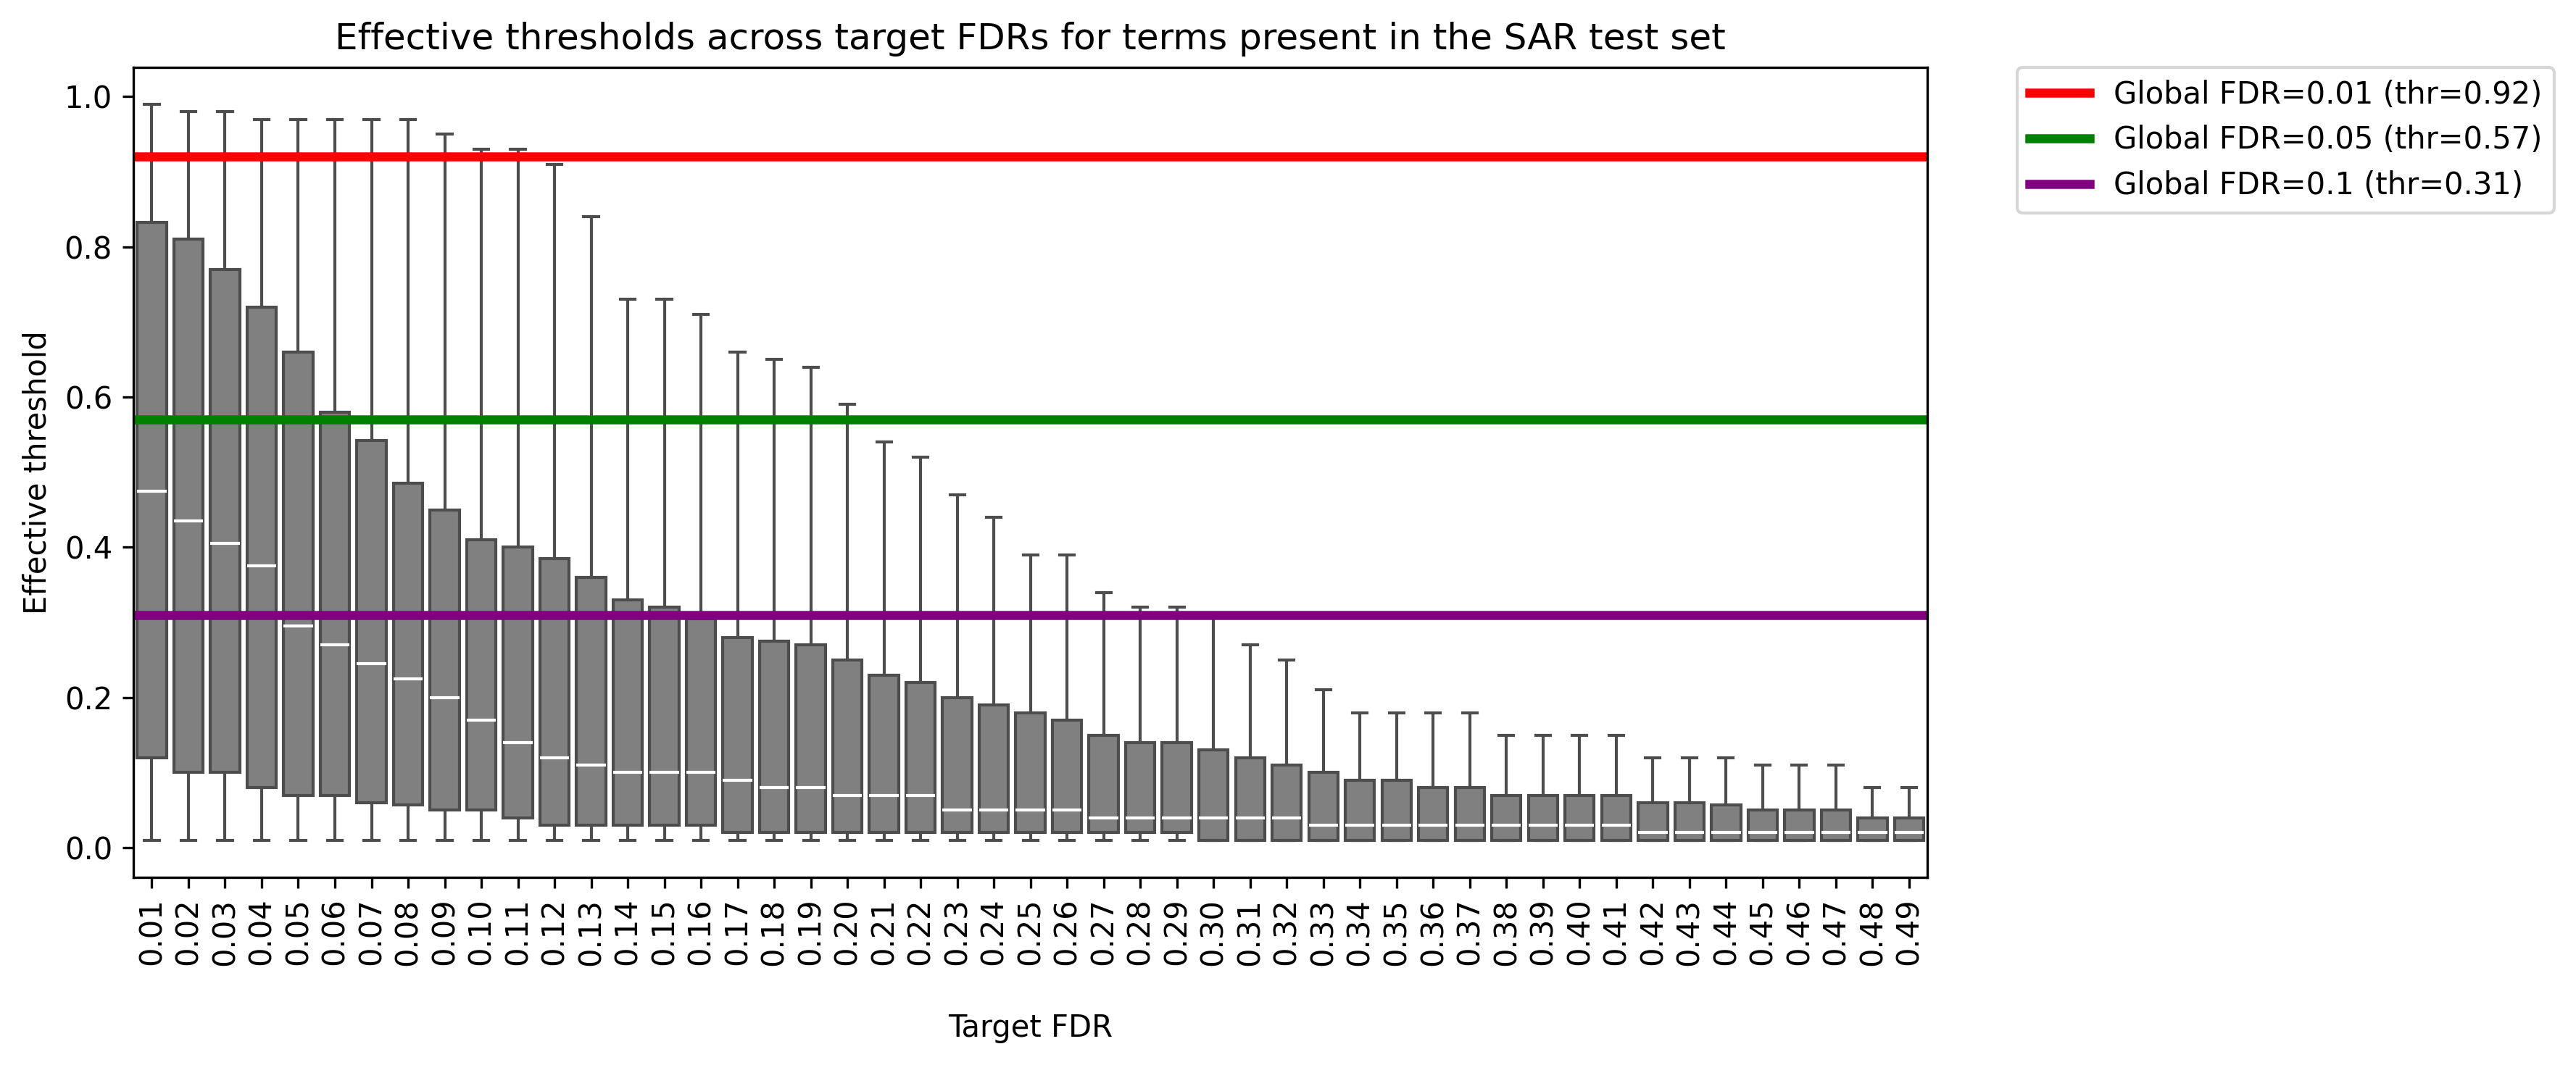

In [ ]:
records = []
for term, fdr_dict in effective_thresholds.items():
    for target_fdr, thr in fdr_dict.items():
        if thr is not None:
            records.append({
                "Term": term,
                "FDR": target_fdr,
                "Threshold": thr
            })
tmp_df = pd.DataFrame(records)

sorted_fdrs = sorted(tmp_df["FDR"].unique())

plt.figure(figsize=(12, 5),dpi=300)

sns.boxplot(
    x="FDR", 
    y="Threshold", 
    data=tmp_df, 
    order=sorted_fdrs,
    color='grey', 
    medianprops=dict(color="white"),
    showfliers=False
)
colors = ['red', 'green', 'purple']  
for (fdr_t, thr), c in zip(global_thresholds.items(), colors):
    plt.axhline(y=thr, color=c, linestyle='-', linewidth=3,
                label=f'Global FDR={fdr_t} (thr={thr:.2f})')

x_ticks = np.arange(0, len(sorted_fdrs), 1)
plt.xticks(x_ticks, [f"{float(fdr):.2f}" for fdr in sorted_fdrs], rotation=90)

plt.title("Effective thresholds across target FDRs for terms present in the SAR test set")
plt.xlabel("\nTarget FDR")
plt.ylabel("Effective threshold")

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.tight_layout()
plt.show()
